In [1]:
import pandas as pd
import numpy as np
import glob
import os
import re
import math
import scipy as sp
from scipy.optimize import curve_fit
from scipy.stats import norm
import statistics
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import container
import matplotlib
%matplotlib widget

In [2]:
plt.rcParams.update({'font.size': 12})

# Importing files as dataframes using their path

In [3]:
data_dict = {}

pathL = Path('../data/raw/Loading/RvsT/')  #importing the warming data files for loading set of experiments
pathUL = Path('../data/raw/Unloading/RvsT/')  #importing the warming data files for unloading set of experiments

for file in pathL.iterdir() :
    if str(file).endswith('.csv'):
        file_num = int(re.split('_', str(file.name))[0]) 
        data_dict[file_num] = pd.read_csv(
        file,
        delimiter='\t',
        usecols=[2, 3],
        skiprows=[0],
        names=['Temp','V']
        ).dropna()
for file in pathUL.iterdir() :
    if str(file).endswith('.csv'): 
        file_num = int(re.split('_', str(file.name))[0])
        data_dict[file_num] = pd.read_csv(
        file,
        delimiter='\t',
        usecols=[2, 3],
        skiprows=[0],
        names=['Temp','V']
        ).dropna()

#Unwanyted file numbers 34 35 36 44 45 46
#Plotting the data files reistance vs temperature data 


In [4]:
dict_CD = {} #declaring dictionary for Current dependence measurements

In [5]:
# #Filtering unwanted files using file number
for file_num in [34, 35, 36 ,44,45,46, 50,51,52]: #files associted with current dependence measurements
    dict_CD[file_num] = data_dict[file_num]
    data_dict.pop(file_num)

In [6]:
data_dict = dict(sorted(data_dict.items()))

In [7]:
data_dict.keys()

dict_keys([2, 10, 14, 17, 20, 23, 26, 29, 32, 33, 39, 41, 43, 48, 49, 53, 54])

### Making a dictionary with pressure values

In [8]:
P = [9.6, 18, 30, 44, 53, 62, 74, 87, 98, 105, 110, 150, 160, 143, 130, 109, 20] #Pressure values for Tc measurements
P_CD = [105, 160, '130*'] #Pressure for current dependence measuremenet

## 1. Plotting Resistance vs Temperature

In [9]:
from matplotlib import colors

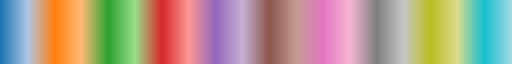

In [10]:
min_val, max_val = 0,1.0
n = 20
orig_cmap = plt.cm.tab20
colors = orig_cmap(np.linspace(min_val, max_val, n))
matplotlib.colors.LinearSegmentedColormap.from_list('cmap', colors)

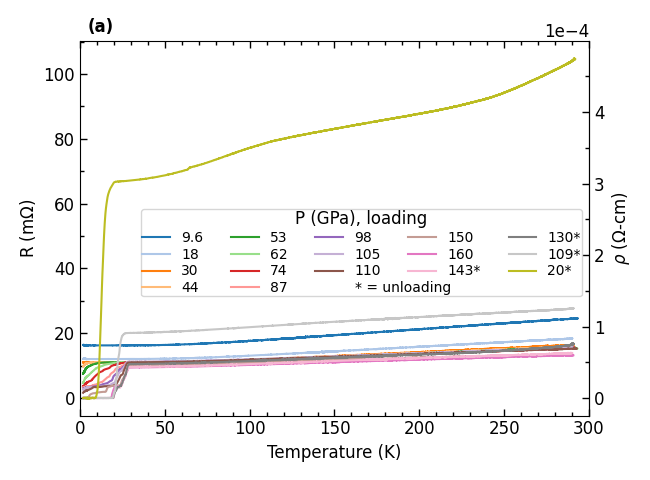

In [11]:
fig, ax = plt.subplots(figsize = (6.5,4.8))
i =0
for file in data_dict.keys(): #Plotting Unloading data files
        df = data_dict[file]
        df['R'] = df.V.rolling(100, center=True).mean()/0.0003 # taking moving average using rolling around center.
        df = df[(df.Temp.diff().abs() < 5) & (df.R<10)]# filtering out the data points where Temperature has offset points due to instrumental noise.
        if file <= 43:  #Files for loading pressure
            ax.plot(df.Temp, df.R*1000, color= colors[i],label=P[i]) #Factor of 1000 to convert to mOhms resistance.
        else:          #Files for unloading pressure
            ax.plot(df.Temp, df.R*1000,color=colors[i], label=str(P[i])+'*')
        i=i+1
    
ax.legend(title ='P (GPa), loading',bbox_to_anchor=(0.0, 0.3, 1., .102),loc = 'lower right', fontsize = 10, borderpad = 0.08, labelspacing = 0.2,ncol = 5).set_zorder(0)

ax.yaxis.tick_left()
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

ax.tick_params(axis="both",which = 'major', direction="in", length=5, width=1, top = True,right = False)
ax.tick_params(axis="both",which = 'minor', direction="in", length=3, width=1, top = True, right = False)
ax.set_xlim(0,300)
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('R (m$\Omega$)')

ax.text(4.3,113,'(a)', fontweight = 'bold')
#adding secondary y-axis for estimated Resistivity
rho = lambda Re : (Re*4.532)/1000000 #Approximate value of (pi*10)/ln(2))*(10^(-4)) using formula for vande-paw set up. For mOhms to Ohm-cm using 10um thickness square sample
Re = lambda rho: (rho/4.532)*1000000
ax2 = ax.secondary_yaxis("right",functions= (rho,Re))
ax2.set_ylabel(r'$\rho$ ($\Omega$-cm)').set_zorder(2) #set_zorder(2) plots text after legend so it is in the front.

ax2.tick_params(axis="y",which = 'major', direction="in", length=5, width=1, top = True,right =True)
ax2.tick_params(axis="y",which = 'minor', direction="in", length=3, width=1, top = True, right = True)
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.text(162,32.8,'* = unloading',fontsize = 10).set_zorder(1)
plt.tight_layout()



In [12]:
plt.savefig('../publication_ready/fig_1a.pdf',bbox_inches='tight')

## Zoomed In Resitance vs Temperature plot with Unloading as inset.

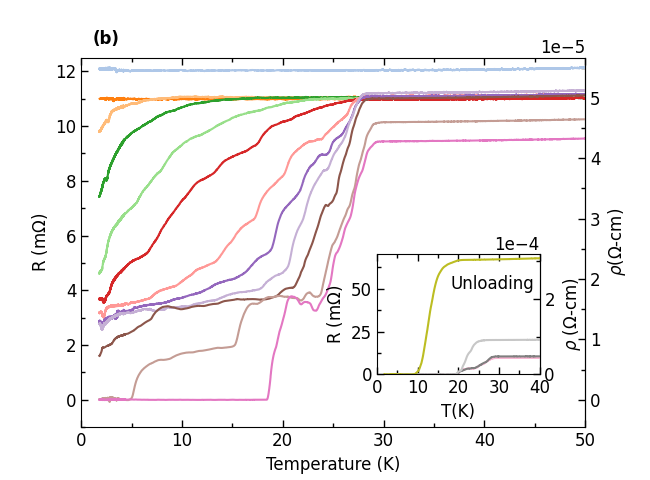

In [13]:
fig, ax = plt.subplots(figsize = (6.5,4.8))
i =0
for file in data_dict.keys():
        df = data_dict[file]
        df['R'] = df.V.rolling(100, center=True).mean()/0.0003 # taking moving average using rolling around center. Using 0.3 mA current to measure voltage
        df = df[(df.Temp.diff().abs() < 5) & (df.R<10)]# filtering out the data points where Temperature has offset points due to instrumental noise.
        if file <= 43:  #Files for loading pressure
            ax.plot(df.Temp, df.R*1000,color = colors[i], label=P[i])
            i=i+1
        else:          #Files for unloading pressure
            continue
        
    
#ax.legend(title ='P (GPa), Unloading',bbox_to_anchor=(0.0, 0.3, 1., .102),loc = 'lower right', borderpad = 0.08, labelspacing = 0.2,ncol = 5)
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(axis="both",which = 'major', direction="in", length=5, width=1, top = True,right = False)
ax.tick_params(axis="both",which = 'minor', direction="in", length=3, width=1, top = True, right = False)

ax.text(1.1,13,'(b)',fontweight = 'bold')
ax.set_xlim(0,50)
ax.set_ylim(-1, 12.5)
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('R (m$\Omega$)')


ax2 = ax.secondary_yaxis("right",functions= (rho,Re))
ax2.set_ylabel(r'$\rho$($\Omega$-cm)')

ax2.tick_params(axis="both",which = 'major', direction="in", length=5, width=1, top = True,right =True)
ax2.tick_params(axis="both",which = 'minor', direction="in", length=3, width=1, top = True, right = True)
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#adding inset graph
left, bottom, width, height = [0.58, 0.22, 0.25, 0.25]
ax3 = fig.add_axes([left, bottom, width, height])
    
for file in data_dict.keys(): #Plotting Unloading data files
        df = data_dict[file]
        df['R'] = df.V.rolling(100, center=True).mean()/0.0003 # taking moving average using rolling around center.
        df = df[(df.Temp.diff().abs() < 5) & (df.R<10)]# filtering out the data points where Temperature has offset points due to instrumental noise.
        if file > 43:  #Files for unloading pressure
            ax3.plot(df.Temp, df.R*1000, color = colors[i],label=str(P[i])+'*')
            i=i+1
        else:          #Files for loading pressure
            continue

ax3.xaxis.set_minor_locator(AutoMinorLocator(4))
ax3.yaxis.set_minor_locator(AutoMinorLocator(2))
ax3.xaxis.set_major_locator(MultipleLocator(5))
ax3.set_xlabel('T(K)')
ax3.set_ylabel('R (m$\Omega$)')
ax3.set_xlim(0,40)
ax3.set_ylim(0,70)
ax3.text(18,50,'Unloading')

ax3.tick_params(axis="both",which = 'major', direction="in", length=5, width=1, top = True,right =False)
ax3.tick_params(axis="both",which = 'minor', direction="in", length=3, width=1, top = True, right = False)
ax3.xaxis.set_minor_locator(AutoMinorLocator(2))
ax3.xaxis.set_major_locator(MultipleLocator(10))

ax3.yaxis.set_minor_locator(AutoMinorLocator(2))

# adding secondary axis to inset plot for estimated resistivity
ax4 = ax3.secondary_yaxis("right",functions= (rho,Re))
ax4.set_ylabel(r'$\rho$ ($\Omega$-cm)')

ax4.tick_params(axis="both",which = 'major', direction="in", length=5, width=1, top = True,right =True)
ax4.tick_params(axis="both",which = 'minor', direction="in", length=3, width=1, top = True, right = True)
ax4.yaxis.set_minor_locator(AutoMinorLocator(2))
ax4.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

#plt.tight_layout()

# ax.legend(title= 'P(GPa)\nLoading',loc='upper right', bbox_to_anchor=(1.3, 1.02))
# ax3.legend(title = 'Unloading',loc='upper right', bbox_to_anchor=(2.376, 0.38))

In [14]:
plt.savefig('../publication_ready/fig_1b.pdf',bbox_inches='tight')

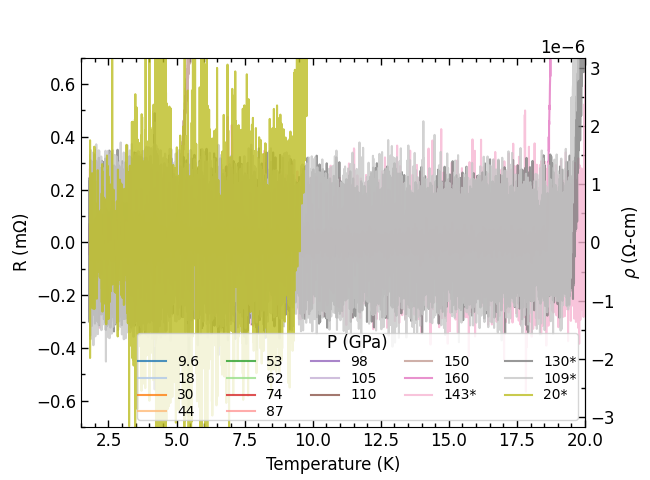

In [15]:
fig, ax = plt.subplots(figsize = (6.5,4.8))
i =0
for file in data_dict.keys(): #Plotting Unloading data files
        df = data_dict[file]
        df['R'] = df.V/0.0003 # taking moving average using rolling around center.
        df = df[(df.Temp.diff().abs() < 5) & (df.R<10)]# filtering out the data points where Temperature has offset points due to instrumental noise.
        if file <= 43:  #Files for loading pressure
            ax.plot(df.Temp, df.R*1000, alpha = 0.8,color= colors[i],label=P[i]) #Factor of 1000 to convert to mOhms resistance.
        else:          #Files for unloading pressure
            ax.plot(df.Temp, df.R*1000,alpha  = 0.8, color=colors[i], label=str(P[i])+'*')
        i=i+1
    
ax.legend(title ='P (GPa)',bbox_to_anchor=(0.0, 0.0, 1., .102),loc = 'lower right', fontsize = 10, borderpad = 0.08, labelspacing = 0.2,ncol = 5).set_zorder(2)

ax.yaxis.tick_left()
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

ax.tick_params(axis="both",which = 'major', direction="in", length=5, width=1, top = True,right = False)
ax.tick_params(axis="both",which = 'minor', direction="in", length=3, width=1, top = True, right = False)
ax.set_xlim(1.5,20)
ax.set_ylim(-0.7,0.7)
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('R (m$\Omega$)')
#ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

#ax.text(2.05,0.106,'(c)', fontweight = 'bold')
#adding secondary y-axis for estimated Resistivity
rho = lambda Re : (Re*4.532)/1000000 #Approximate value of (pi*10)/ln(2))*(10^(-4)) using formula for vande-paw set up. For mOhms to Ohm-cm using 10um thickness square sample
Re = lambda rho: (rho/4.532)*1000000
ax2 = ax.secondary_yaxis("right",functions= (rho,Re))
ax2.set_ylabel(r'$\rho$ ($\Omega$-cm)').set_zorder(2) #set_zorder(2) plots text after legend so it is in the front.

ax2.tick_params(axis="y",which = 'major', direction="in", length=5, width=1, top = True,right =True)
ax2.tick_params(axis="y",which = 'minor', direction="in", length=3, width=1, top = True, right = True)
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#ax.text(162,32.8,'* = Pressure being released',fontsize = 10).set_zorder(1)
#plt.tight_layout()



In [16]:
plt.savefig('../publication_ready/fig_S2a.pdf', bbox_inches = 'tight')

## 2. Plotting Tc vs P

In [17]:
#Using Voltage at 30 K as the V(100%) at onset
V_N= [] # empty list for normal state voltage at 300 K
i = 0;
for f in data_dict:    
    #print(data_dict[f].query("(Temp >29.5)&(Temp<31.5)")["V"].mean())
    V_N.append(data_dict[f].query("(Temp >29.5)&(Temp<31.5)")["V"].mean())
    i=i+1;

### 2(a). Getting Tc 90%, Tc 50% and Tc 10%

In [18]:
j=0
Tc_90= []
Tc_50 = []
Tc_10= []
for file in data_dict:
    pos90 = abs(data_dict[file].V-(0.9*V_N[j])).abs().idxmin() #This fails for incomplete transitions
    if abs((100*(data_dict[file].V[pos90]-V_N[j])/V_N[j])) < 9.5:
        Tc_90.append(np.NaN)
    else:
         Tc_90.append(data_dict[file].Temp[pos90])
        
    pos50 = abs(data_dict[file].V-(0.5*V_N[j])).abs().idxmin() #This fails for incomplete transitions
    if abs((100*(data_dict[file].V[pos50]-V_N[j])/V_N[j])) < 49.5:
        Tc_50.append(np.NaN)
    else: 
        Tc_50.append(data_dict[file].Temp[pos50])
        
    pos10 = abs(data_dict[file].V-(0.1*V_N[j])).abs().idxmin() #This fails for incomplete transitions
    if abs((100*(data_dict[file].V[pos10]-V_N[j])/V_N[j])) < 89.5:
        Tc_10.append(1.8)
    else: 
        Tc_10.append(data_dict[file].Temp[pos10])    
    j = j+1

In [19]:
#importind data for pure MoB2 (Pei et al.)
df_mob2 = pd.read_csv('../data/external/MoB2_data/combined.csv', skiprows = [0],names = ['Pressure', 'Tc'])

### 2(b). Plotting Tc vs P with errorbars

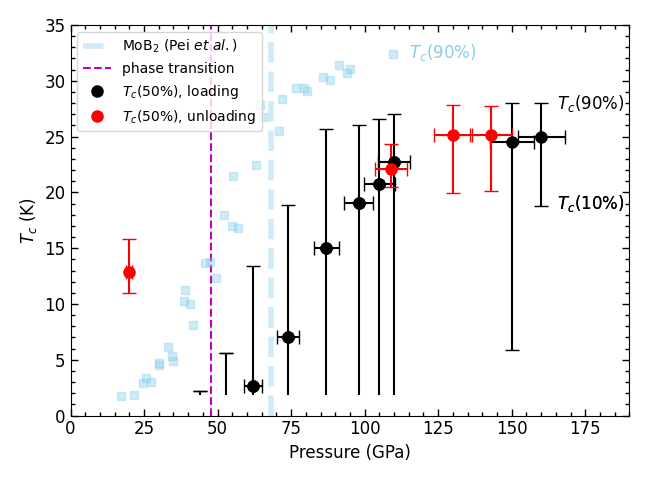

In [20]:
fig, ax = plt.subplots(figsize = (6.5,4.8))
yerr_min = np.array(Tc_50) - np.array(Tc_10)
yerr_max = np.array(Tc_90) - np.array(Tc_50)
y_err = [yerr_min, yerr_max]
#x_err = 0.1*np.array(P) 
ax.errorbar(P[3:5],Tc_90[3:5],yerr = [np.array(Tc_90[3:5])-1.8*np.ones(2), np.zeros(2),], fmt = '',color = 'k', ls = 'none') 
ax.errorbar(P[3:5],Tc_90[3:5],yerr = 0, fmt = '',solid_capstyle= 'projecting', capsize = 5,color = 'k', ls = 'none')
ax.errorbar(P[4:11],Tc_50[4:11], yerr= [yerr_min[4:11], np.zeros(7)],  fmt = 'o', markersize=8, color = 'k') #, solid_capstyle='projecting', capsize=5
ax.errorbar(P[5:11],Tc_50[5:11], yerr= [np.zeros(6), yerr_max[5:11]], xerr = 0.05*np.array(P[5:11]), fmt = 'o', markersize=8, solid_capstyle='projecting', capsize = 5, 
            color = 'k', 
            label= '$T_c$(50%), loading')
ax.errorbar(P[11:13], Tc_50[11:13], yerr = [yerr_min[11:13],yerr_max[11:13]], xerr = 0.05*np.array(P[11:13]), fmt = 'o', markersize = 8, solid_capstyle = 'projecting', 
            capsize = 5, color = 'k')
ax.errorbar(P[13:18], Tc_50[13:18], yerr = [yerr_min[13:18],yerr_max[13:18]], xerr = 0.05*np.array(P[13:18]), fmt = 'o', markersize = 8, solid_capstyle= 'projecting', 
            capsize = 5, color = 'r', label = '$T_c$(50%), unloading')
ax.vlines(68, 0,35,'m','dashed', label = 'MoB$_2$ (Pei $et$ $al.$)', alpha = 0.4, linewidth = 4, color = 'skyblue')
ax.vlines(47.712, 0,35,'m','dashed', label = 'phase transition')
ax.plot(df_mob2.Pressure, df_mob2.Tc, 's', alpha = 0.4, color= 'skyblue')
ax.set_xlabel('Pressure (GPa)')
ax.set_ylabel('$T_c$ (K)')
#ax.legend(loc = 'upper left', borderpad = 0.08, labelspacing = 0.2,ncol = 1)
handles, labels = ax.get_legend_handles_labels()
handles = [h[0] if isinstance(h, container.ErrorbarContainer) else h for h in handles]


ax.text(115.2,32.0,'$T_c$(90%)', color = 'skyblue')
ax.text(165.5,27.5,'$T_c$(90%)')
ax.text(165.5,18.5,'$T_c$(10%)')
ax.text(165.5,18.5,'$T_c$(10%)')

ax.legend(handles, labels, loc = 'upper left', fontsize = 10)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.tick_params(axis="both",which = 'major', direction="in", length=5, width=1, top = True,right = True)
ax.tick_params(axis="both",which = 'minor', direction="in", length=3, width=1, top = True, right = True)
ax.set_xlim(0,190)
ax.set_ylim(0,35)
plt.tight_layout()

In [21]:
plt.savefig('../publication_ready/fig_7.pdf', bbox_inches = 'tight')

## 3. Change in Resistance with pressure at different temperatures

In [22]:
R_285= []
R_150 = []
R_30 = []# empty list for normal state voltage at 300 K
i = 0
for f in data_dict:    
    V285 = data_dict[f].query("(Temp >284.5)&(Temp<285.5)")["V"].mean()
    V150 = data_dict[f].query("(Temp >149.5)&(Temp<150.5)")["V"].mean()
    V10 = data_dict[f].query("(Temp >29.9)&(Temp<30.1)")["V"].mean()
    R_285.append(V285/0.0000003) # in milliOhms
    R_150.append(V150/0.0000003)
    R_30.append(V10/0.0000003)
    i=i+1;

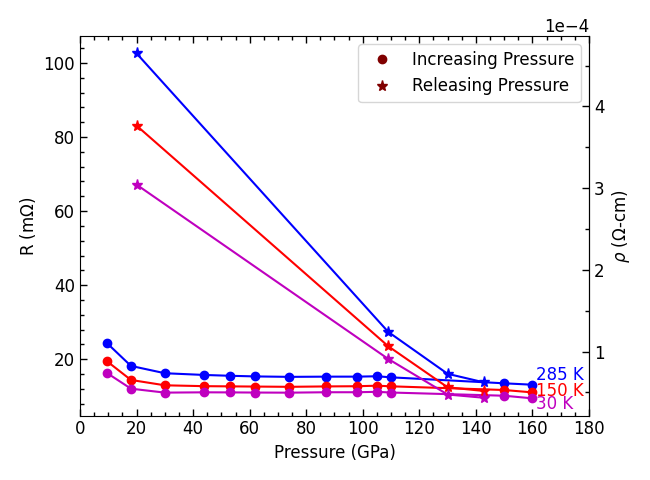

In [23]:
import matplotlib.lines as mlines
fig,ax = plt.subplots(figsize = (6.5,4.8))
#Plotting Loading data

ax.plot(P[0:13], R_285[0:13], '-o', color = 'b', )
ax.plot(P[0:13], R_150[0:13], '-o', color = 'r')
ax.plot(P[0:13], R_30[0:13], '-o', color = 'm')

#Plotting Unloading

ax.plot(P[13:18], R_285[13:18], '-*',markersize = 8, color = 'b')
ax.plot(P[13:18], R_150[13:18], '-*', markersize = 8, color = 'r')
ax.plot(P[13:18], R_30[13:18], '-*',markersize = 8, color = 'm')

ax.text(161.4,14.45, '285 K', color = 'b')
ax.text(161.4,10.2, '150 K', color = 'r')
ax.text(161.4,6.45, '30 K', color = 'm')
ax.set_xlabel('Pressure (GPa)')
ax.set_ylabel('R (m$\Omega$)')

#Defining Legend handles, Defining empty lines for legend handles

sphere = mlines.Line2D([],[],color = 'maroon',marker = 'o', linestyle = 'None',
                       markersize = 6, label = 'Increasing Pressure')
star = mlines.Line2D([], [], color='maroon', marker='*', linestyle='None',
                          markersize=8, label='Releasing Pressure')

ax.legend(handles = [sphere,star])
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.xaxis.set_major_locator(MultipleLocator(20))
ax.tick_params(axis="both",which = 'major', direction="in", length=5, width=1, top = True,right = False)
ax.tick_params(axis="both",which = 'minor', direction="in", length=3, width=1, top = True, right = False)
ax.set_xlim(0,180)

#adding secondary y-axis for estimated Resistivity
rho = lambda Re : (Re*4.532)/1000000 #Approximate value of (pi*10)/ln(2))*(10^(-4)) using formula for vande-paw set up. For mOhms to Ohm-cm using 10um thickness square sample
Re = lambda rho: (rho/4.532)*1000000
ax2 = ax.secondary_yaxis("right",functions= (rho,Re))
ax2.set_ylabel(r'$\rho$ ($\Omega$-cm)').set_zorder(2) #set_zorder(2) plots text after legend so it is in the front.

ax2.tick_params(axis="y",which = 'major', direction="in", length=5, width=1, top = True,right =True)
ax2.tick_params(axis="y",which = 'minor', direction="in", length=3, width=1, top = True, right = True)
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tight_layout()


In [24]:
RRR = np.divide(R_285,R_30)

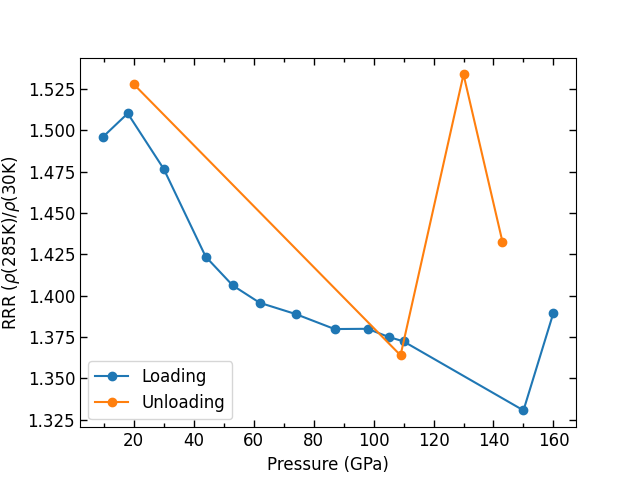

In [25]:
fig, ax = plt.subplots()
ax.plot(P[0:13], RRR[0:13],'-o', label = 'Loading')
ax.plot(P[13:], RRR[13:], '-o', label = 'Unloading')
ax.set_xlabel('Pressure (GPa)')
ax.set_ylabel(r'RRR ($\rho$(285K)/$\rho$(30K)')
ax.legend()
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(1))
ax.xaxis.set_major_locator(MultipleLocator(20))
ax.tick_params(axis="both",which = 'major', direction="in", length=5, width=1, top = True,right = True)
ax.tick_params(axis="both",which = 'minor', direction="in", length=3, width=1, top = True, right = True)

In [26]:
plt.savefig('../publication_ready/fig_S2b.pdf',bbox_inches='tight')

(0.0, 180.0)

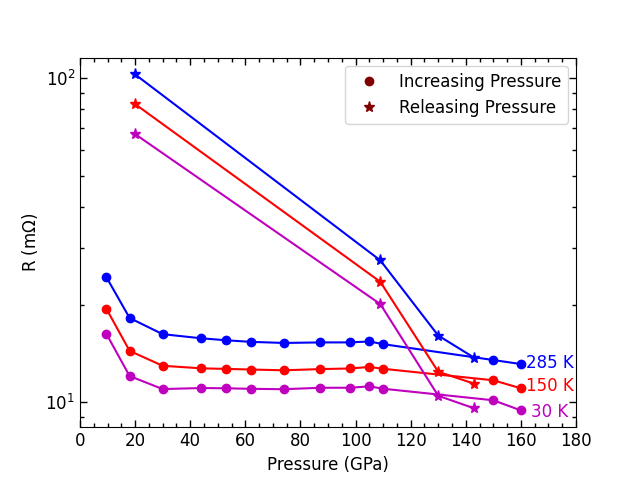

In [27]:
fig,ax = plt.subplots()
#Plotting Loading data

ax.semilogy(P[0:13], R_285[0:13], '-o', color = 'b', )
ax.semilogy(P[0:13], R_150[0:13], '-o', color = 'r')
ax.semilogy(P[0:13], R_30[0:13], '-o', color = 'm')

#Plotting Unloading

ax.semilogy(P[13:18], R_285[13:18], '-*',markersize = 8, color = 'b')
ax.semilogy(P[13:18], R_150[13:18], '-*', markersize = 8, color = 'r')
ax.semilogy(P[13:18], R_30[13:18], '-*',markersize = 8, color = 'm')

ax.text(162,12.8, '285 K', color = 'b')
ax.text(162,10.8, '150 K', color = 'r')
ax.text(163.5,9, '30 K', color = 'm')
ax.set_xlabel('Pressure (GPa)')
ax.set_ylabel('R (m$\Omega$)')
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.xaxis.set_major_locator(MultipleLocator(20))
#Defining Legend handles, Defining empty lines for legend handles

sphere = mlines.Line2D([],[],color = 'maroon',marker = 'o', linestyle = 'None',
                       markersize = 6, label = 'Increasing Pressure')
star = mlines.Line2D([], [], color='maroon', marker='*', linestyle='None',
                          markersize=8, label='Releasing Pressure')
ax.legend(handles = [sphere,star])
ax.tick_params(axis="both",which = 'major', direction="in", length=5, width=1, top = True,right = True)
ax.tick_params(axis="both",which = 'minor', direction="in", length=3, width=1, top = True, right = True)
ax.set_xlim(0,180)

        

In [28]:
plt.savefig('../publication_ready/fig_2.pdf')

### 4. Plotting Current Dependence at different pressure

In [29]:
dict_CD[50].drop(dict_CD[50].index[0:26160], inplace = True)
dict_CD[51].drop(dict_CD[51].index[0:8612], inplace = True)
dict_CD[52].drop(dict_CD[52].index[0:7912], inplace = True)

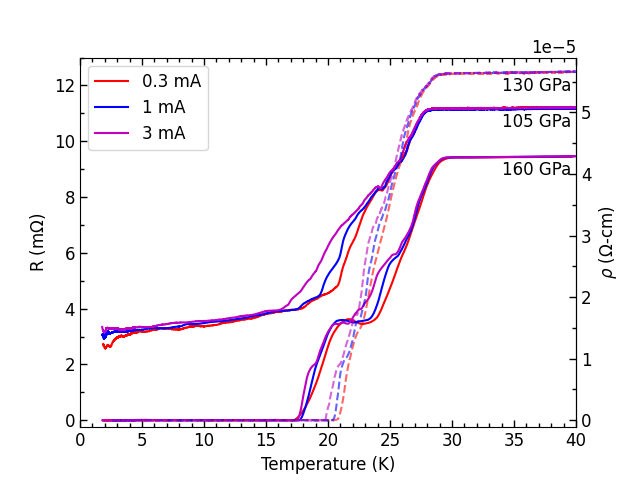

In [30]:
fig,ax = plt.subplots()
for file in dict_CD:   
    
    df = dict_CD[file][dict_CD[file].Temp<40]
    #Current Dependence at 104 and 155 GPa
    if file in [34, 44]:  
        ax.plot(df.Temp, df.V.rolling(100, center=True).mean()/0.0000003, color = 'r')
    elif file in [35, 45]: 
        ax.plot(df.Temp, df.V.rolling(50,center=True).mean()/0.000001, color = 'b')
    elif file in [36, 46]: 
        ax.plot(df.Temp, df.V.rolling(20, center=True).mean()/0.000003, color = 'm')
        #Showing unloading data as faded 123 GPa
    if file == 50:
        ax.plot(df.Temp, df.V.rolling(100, center=True).mean()/0.0000003, linestyle= 'dashed',color = 'r', alpha = 0.6)
    elif file == 51:
        ax.plot(df.Temp, df.V.rolling(50, center=True).mean()/0.000001,linestyle= 'dashed', color = 'b', alpha = 0.6)
    elif file == 52:
        ax.plot(df.Temp, df.V.rolling(20, center=True).mean()/0.000003, linestyle= 'dashed',color = 'm', alpha = 0.6)
        

ax.text(34,10.5, '105 GPa',color = 'k')
ax.text(34,11.8, '130 GPa', color = 'k')
ax.text(34,8.8, '160 GPa', color = 'k')

ax.legend(['0.3 mA','1 mA','3 mA'])
ax.set_xlim(0, 40)
ax.set_ylim(-0.25, 13)
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('R (m$\Omega$)')
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.tick_params(axis="both",which = 'major', direction="in", length=5, width=1, top = True,right = False)
ax.tick_params(axis="both",which = 'minor', direction="in", length=3, width=1, top = True, right = False)


#adding secondary y-axis for estimated Resistivity
rho = lambda Re : (Re*4.532)/1000000 #Approximate value of (pi*10)/ln(2))*(10^(-4)) using formula for vande-paw set up. For mOhms to Ohm-cm using 10um thickness square sample
Re = lambda rho: (rho/4.532)*1000000
ax2 = ax.secondary_yaxis("right",functions= (rho,Re))
ax2.set_ylabel(r'$\rho$ ($\Omega$-cm)').set_zorder(2) #set_zorder(2) plots text after legend so it is in the front.

ax2.tick_params(axis="y",which = 'major', direction="in", length=5, width=1, top = True,right =True)
ax2.tick_params(axis="y",which = 'minor', direction="in", length=3, width=1, top = True, right = True)
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

In [31]:
plt.savefig('../publication_ready/fig_3.pdf')